# Intuit Refund ETA Prediction

This notebook demonstrates how to:
- Generate mock tax refund data
- Train an XGBoost regression model
- Predict refund arrival times
- Explain predictions with SHAP

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
import seaborn as sns
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import PartialDependenceDisplay
from train_model import train_model, categorical_cols

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Read generated fake data
df = pd.read_csv("../generated/training_data.csv")

# Quick preview
df.head()

,filing_method,filing_time_category,bank_deposit_type,geo_region,prior_credits_claimed,has_return_errors,requires_id_verification,is_selected_for_manual_review,claimed_eitc,claimed_actc,is_amended_return,has_injured_spouse_claim,has_offset_debts,prior_refund_delayed,prior_id_verification_flagged,has_bank_info_on_file,num_days_since_filed,return_completeness_score,prior_refund_processing_time,refund_delay_days
0,efile_direct_deposit,early,unknown,west,many,1,0,1,1,1,0,0,0,1,1,1,25.991547,0.520531,22.987541,8.440355
1,paper_paper_check,normal,third_party_processor,midwest,none,0,1,0,0,0,0,0,1,1,1,1,41.396831,0.653922,8.529719,8.405415
2,paper_direct_deposit,late,prepaid_card,midwest,few,1,0,0,1,0,1,1,0,1,0,0,40.281227,0.727078,18.451515,6.908884
3,efile_paper_check,late,unknown,midwest,few,0,0,1,1,0,1,0,0,1,1,1,38.465437,0.677476,10.315350,6.022627
4,efile_paper_check,early,traditional_bank,west,many,0,1,1,0,0,0,0,0,0,1,0,31.915636,0.698038,9.732512,8.687174


In [3]:
# Train model
res = train_model("../generated/training_data.csv")

print("X_train types:")
print(res.X_train.dtypes.value_counts())

y_pred = res.model.predict(res.dtest)
rmse = root_mean_squared_error(res.y_test, y_pred)

print(f"RMSE: {rmse:.2f} days")

X_train types:
bool       21
int64      11
float64     3
Name: count, dtype: int64
RMSE: 1.88 days


In [1]:
# Use the model to predict a tax refund time

# Define a test user record (raw, not encoded)
test_record = {
    "filing_method": "efile_direct_deposit",
    "filing_time_category": "early",
    "bank_deposit_type": "traditional_bank",
    "geo_region": "west",
    "prior_credits_claimed": "few",

    "has_return_errors": 0,
    "requires_id_verification": 0,
    "is_selected_for_manual_review": 0,
    "claimed_eitc": 1,
    "claimed_actc": 0,
    "is_amended_return": 0,
    "has_injured_spouse_claim": 0,
    "has_offset_debts": 0,
    "prior_refund_delayed": 0,
    "prior_id_verification_flagged": 0,
    "has_bank_info_on_file": 1,

    "num_days_since_filed": 12,
    "return_completeness_score": 0.95,
    "prior_refund_processing_time": 10
}

# Convert to DataFrame
sample_user = pd.DataFrame([test_record])

# One-hot encode the same categorical columns
sample_user_encoded = pd.get_dummies(sample_user, columns=categorical_cols)

model_features = list(res.X_encoded.columns)

# Ensure all columns match the model
for col in model_features:
    if col not in sample_user_encoded.columns:
        sample_user_encoded[col] = 0

# Reorder columns to match training data
sample_user_encoded = sample_user_encoded[model_features]

# Check dtypes
print(sample_user_encoded.dtypes.value_counts())

# Create DMatrix
d_sample = xgb.DMatrix(sample_user_encoded)

# Predict
pred_delay = res.model.predict(d_sample)

print(f"Predicted refund delay: {pred_delay[0]:.2f} days")

NameError: name 'pd' is not defined

In [5]:
# Use SHAP to explain prediction
explainer = shap.TreeExplainer(res.model)
shap_values = explainer.shap_values(sample_user_encoded)

shap.initjs()

shap.force_plot(
    explainer.expected_value,
    shap_values,
    sample_user_encoded
)

In [6]:
# Output reasons for delay
reasons = {
    key: float(value)
    for key, value in zip(sample_user.columns, shap_values[0])
}

# Convert to DataFrame
reasons_df = pd.DataFrame(
    list(reasons.items()),
    columns=["Feature", "SHAP Value"]
)

# Sort by absolute SHAP value
reasons_df = reasons_df.reindex(
    reasons_df["SHAP Value"].abs().sort_values(ascending=False).index
)

reasons_df

,Feature,SHAP Value
3,geo_region,-0.747204
14,prior_id_verification_flagged,-0.646020
9,claimed_actc,0.053480
12,has_offset_debts,0.053468
8,claimed_eitc,-0.032719
11,has_injured_spouse_claim,-0.029952
7,is_selected_for_manual_review,-0.014251
10,is_amended_return,0.013151
1,filing_time_category,0.011981
15,has_bank_info_on_file,-0.006490


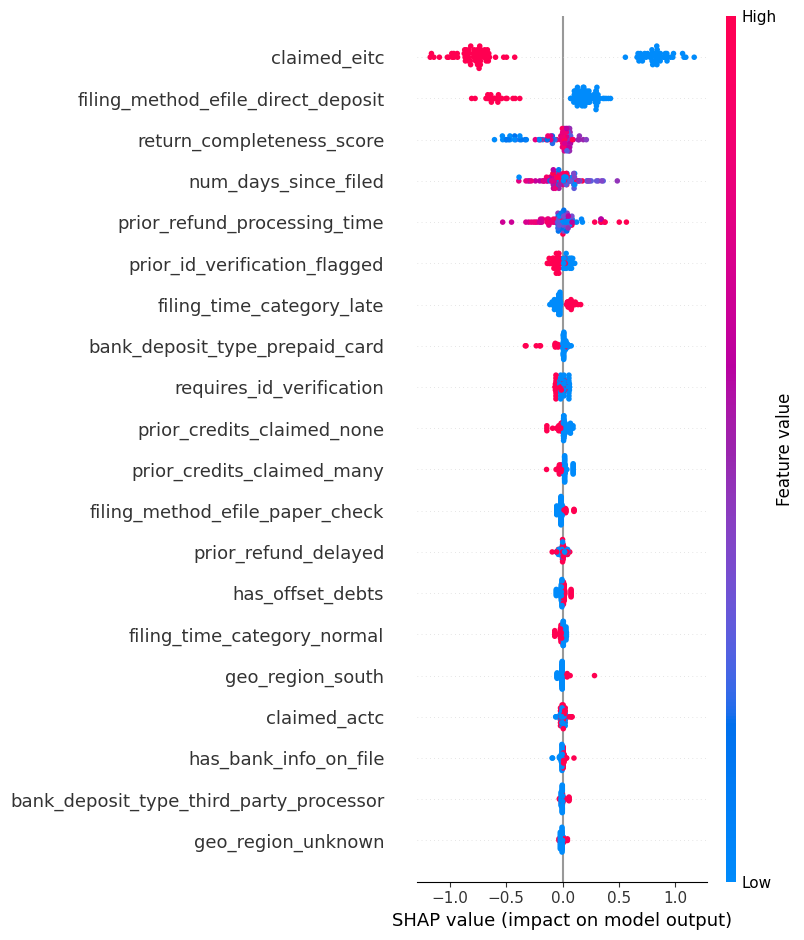

In [7]:
# Compute SHAP values for entire test set
shap_values_all = explainer.shap_values(res.X_test)

# Plot summary
shap.summary_plot(shap_values_all, res.X_test)

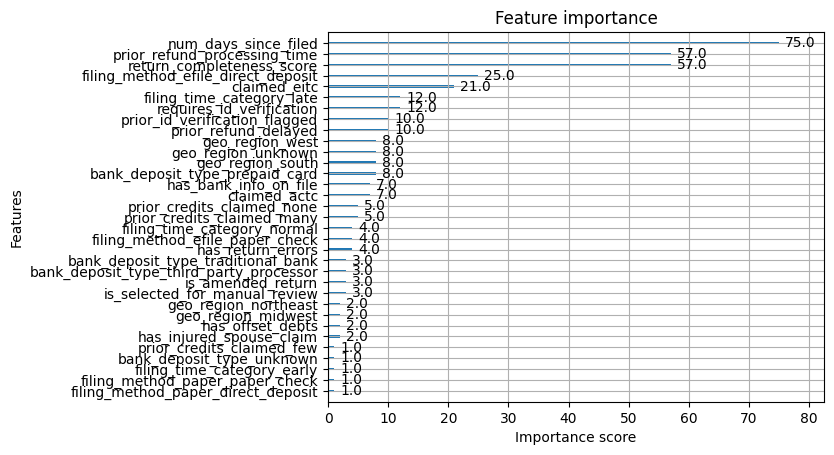

In [8]:
xgb.plot_importance(res.model)
plt.show()

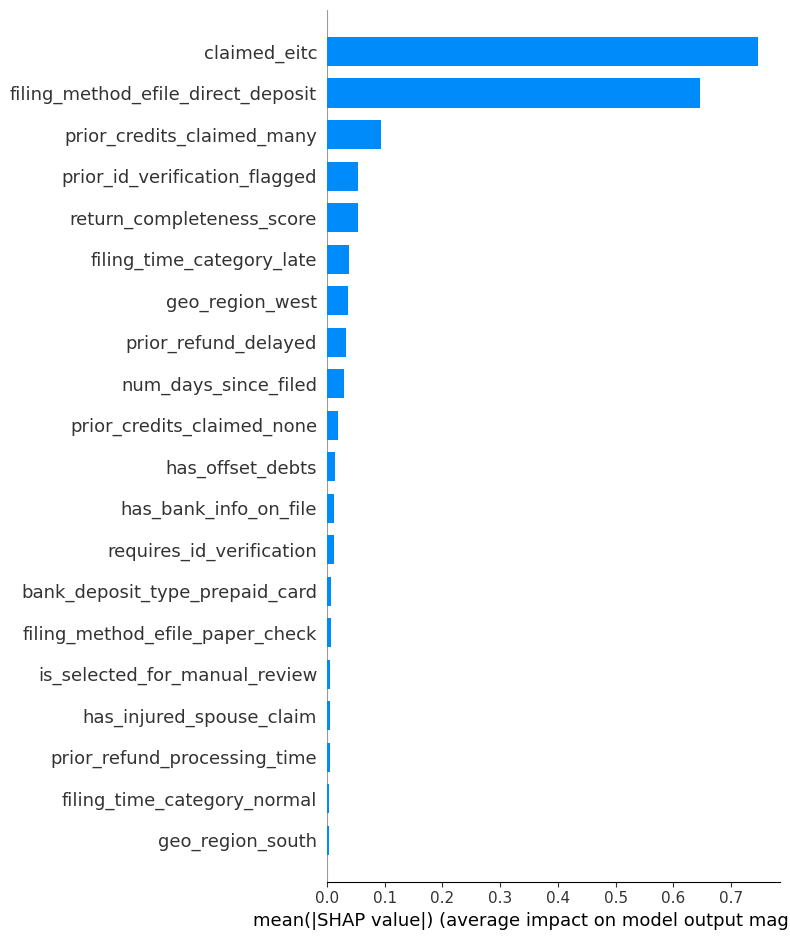

In [9]:
shap.summary_plot(shap_values, res.X_test, plot_type="bar")

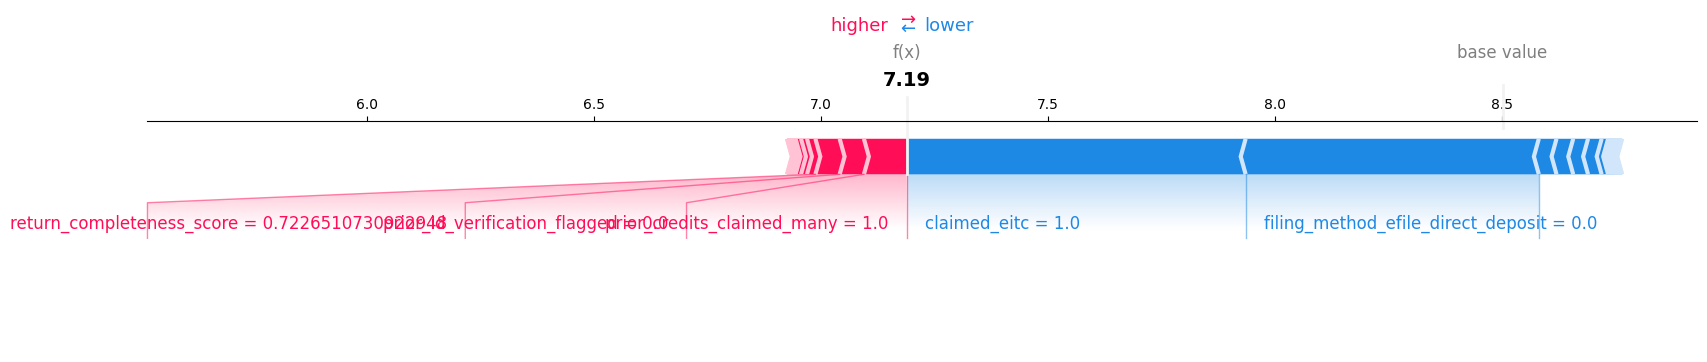

In [10]:
shap.force_plot(
    explainer.expected_value,
    shap_values[0],
    res.X_test.iloc[0],
    matplotlib=True
)

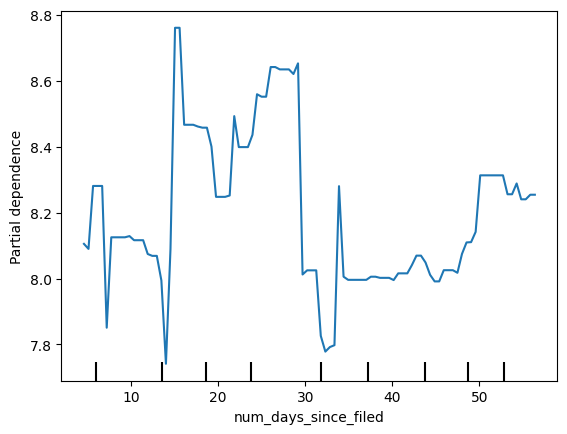

In [11]:
# Train with scikit-learn API
trained_model_reg = XGBRegressor(
    objective="reg:squarederror",
    max_depth=4,
    eta=0.1,
    n_estimators=100,
)

trained_model_reg.fit(res.X_train, res.y_train)

PartialDependenceDisplay.from_estimator(
    trained_model_reg,
    res.X_test,
    ["num_days_since_filed"]
)

plt.show()

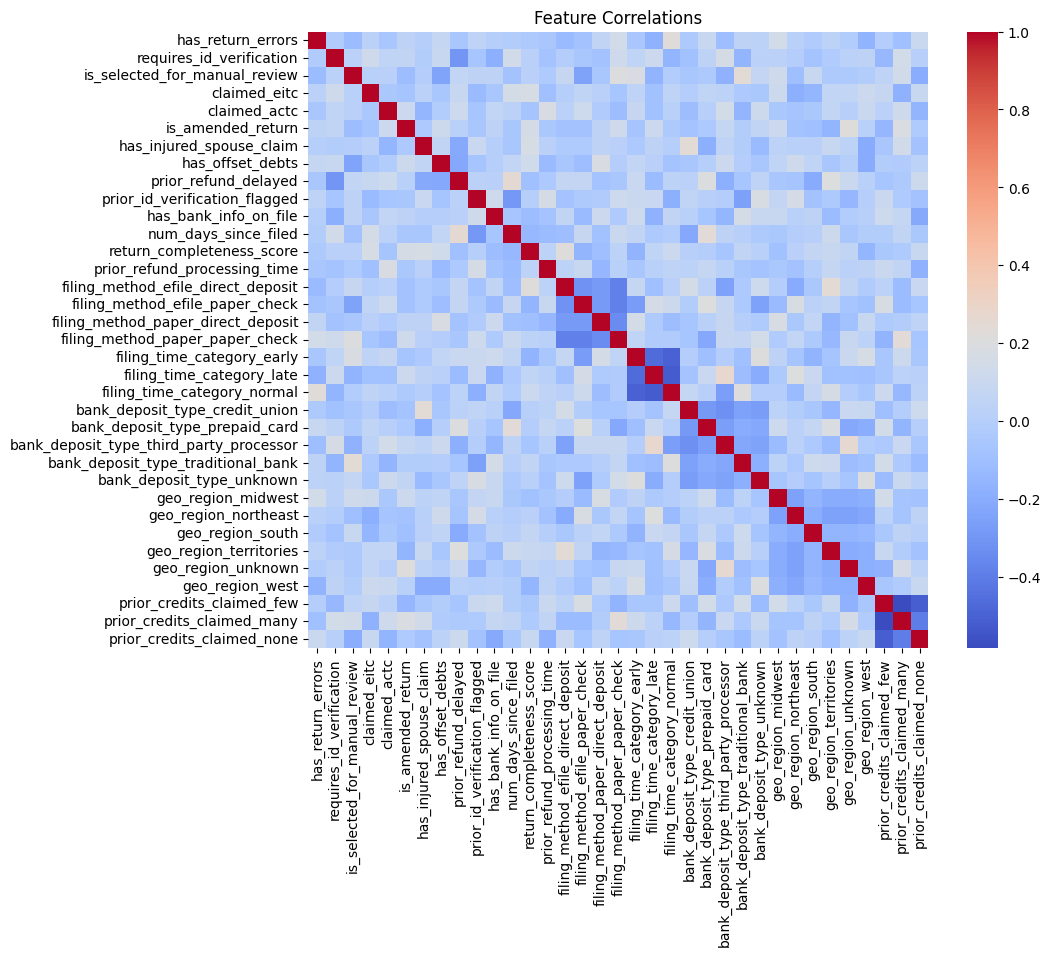

In [12]:
corr = res.X_test.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm")
plt.title("Feature Correlations")
plt.show()

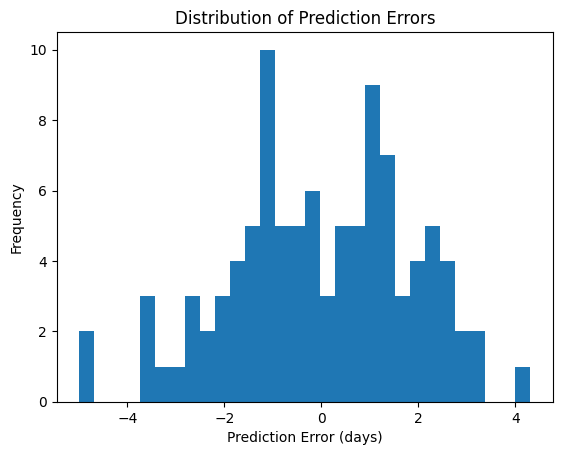

In [13]:
errors = res.y_test - y_pred
plt.hist(errors, bins=30)
plt.xlabel("Prediction Error (days)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

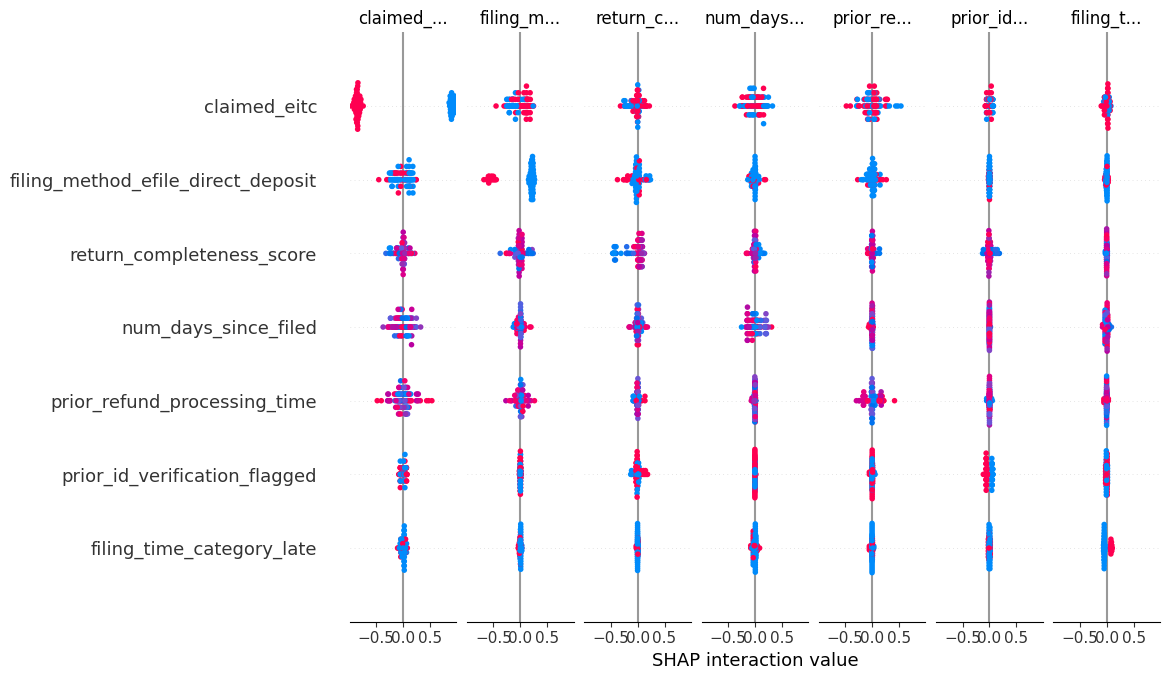

In [14]:
shap_interaction_values = explainer.shap_interaction_values(res.X_test)
shap.summary_plot(shap_interaction_values, res.X_test)

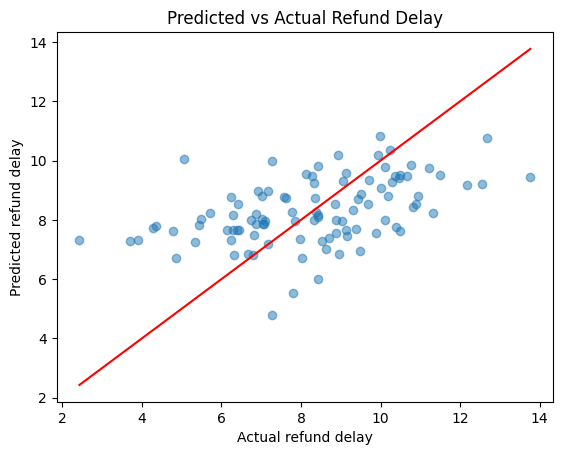

In [15]:
plt.scatter(res.y_test, y_pred, alpha=0.5)
plt.plot([res.y_test.min(), res.y_test.max()], [res.y_test.min(), res.y_test.max()], color='red')
plt.xlabel("Actual refund delay")
plt.ylabel("Predicted refund delay")
plt.title("Predicted vs Actual Refund Delay")
plt.show()